In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder

In [2]:
CLN_DATA_PATH='../data/codon_df_clean.csv'

try:
    codon_df_clean = pd.read_csv(CLN_DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: The data file does not exist.")

Data loaded successfully.


In [4]:
kingdom_mapped = ['vrl', 'arc', 'bct', 'phg', 'plm', 'pln', 'inv', 'vrt', 'mam', 'rod', 'pri' ]
label_encoder = LabelEncoder()

codon_df_clean['Kingdom_labels'] = label_encoder.fit_transform(codon_df_clean['Kingdom'])
codon_df_clean[['Kingdom_labels','Kingdom']].value_counts()


Kingdom_labels  Kingdom
1               bct        2919
9               vrl        2831
6               pln        2523
10              vrt        2077
2               inv        1345
3               mam         572
4               phg         220
8               rod         215
7               pri         180
0               arc         126
5               plm          18
Name: count, dtype: int64

In [5]:
#codon_df_clean['Kingdom'] = codon_df_clean['Kingdom'].replace({
#    'vrl': 'virus_bacteriophage',
#    'phg': 'virus_bacteriophage',
#    'vrt': 'animalia',
#    'pln': 'plantae',
#    'bct': 'bacteria',
#    'arc': 'archaea',
#    'inv': 'animalia',
#    'mam': 'animalia',
#    'rod': 'animalia',
#    'pri': 'animalia'
#})


In [6]:
#codon_df_clean = codon_df_clean[codon_df_clean['Kingdom'] != 'plm']

## Bayes model 


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
X = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y= codon_df_clean['Kingdom_labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [7]:
scaler_GNB = StandardScaler()

scaler_GNB.fit(X_train)

X_train_scaled = scaler_GNB.transform(X_train)
X_test_scaled = scaler_GNB.transform(X_test)

In [8]:
bayes = GaussianNB()

bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [9]:
print(f'Accuracy on train set: {bayes.score(X_train, y_train)}')
print(f'Accuracy on test set: {bayes.score(X_test, y_test)}')

Accuracy on train set: 0.19404990403071018
Accuracy on test set: 0.19224865694551035


c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


In [10]:
y_train_pred = bayes.predict(X_train_scaled)
y_test_pred = bayes.predict(X_test_scaled)

In [11]:
report_train_GNB = classification_report(y_train, y_train_pred)
print(report_train_GNB)

              precision    recall  f1-score   support

           0       0.21      0.68      0.32        97
           1       0.66      0.38      0.48      2335
           2       0.53      0.36      0.43      1061
           3       0.48      0.71      0.58       461
           4       0.18      0.79      0.30       176
           5       0.03      0.92      0.06        12
           6       0.89      0.39      0.55      2022
           7       0.29      0.25      0.27       141
           8       0.38      0.54      0.45       175
           9       0.51      0.91      0.65      2264
          10       0.94      0.56      0.70      1676

    accuracy                           0.55     10420
   macro avg       0.47      0.59      0.43     10420
weighted avg       0.68      0.55      0.56     10420



In [12]:
report_test_GNB = classification_report(y_test, y_test_pred)
print(report_test_GNB)

              precision    recall  f1-score   support

           0       0.30      0.62      0.40        29
           1       0.66      0.36      0.46       584
           2       0.53      0.39      0.45       284
           3       0.50      0.78      0.61       111
           4       0.20      0.86      0.32        44
           5       0.03      0.50      0.06         6
           6       0.91      0.41      0.57       501
           7       0.32      0.23      0.27        39
           8       0.33      0.47      0.39        40
           9       0.52      0.92      0.67       567
          10       0.93      0.57      0.70       401

    accuracy                           0.56      2606
   macro avg       0.47      0.56      0.45      2606
weighted avg       0.67      0.56      0.56      2606



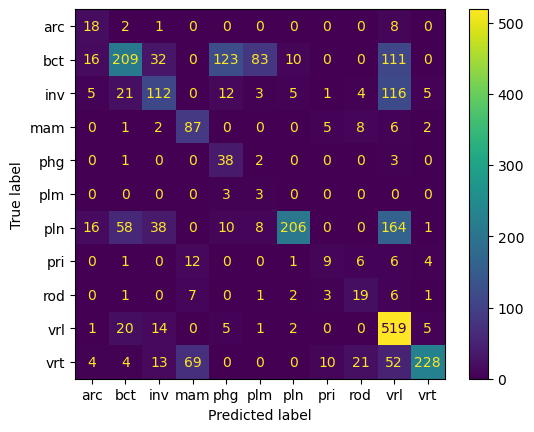

In [13]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

## Logistic Regression


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

In [15]:
X_1 = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y_1= codon_df_clean['Kingdom_labels']


X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X_1, y_1, test_size=0.2, random_state=34)

In [16]:
print(X_train_lg.shape)
print (y_train_lg.shape)

(10420, 66)
(10420,)


In [17]:
estimators_lg = [('normalise', StandardScaler()),
              ('reduce_dim', PCA()),
              ('lg', LogisticRegression(n_jobs=4, random_state=34, max_iter=10000))]

pipe_lg = Pipeline(estimators_lg)
print(pipe_lg)

Pipeline(steps=[('normalise', StandardScaler()), ('reduce_dim', PCA()),
                ('lg',
                 LogisticRegression(max_iter=10000, n_jobs=4,
                                    random_state=34))])


In [18]:
n_components = list(range(40, 51, 1))

# params for LogisticRegression()
# C values
C = [0.001, 0.01, 0.1, 1, 10, 100] 

#define the parameter grid
params_lg = dict(
    reduce_dim__n_components = n_components,
    lg__C = C,
)
print(f"parameter grid values: {params_lg}")

parameter grid values: {'reduce_dim__n_components': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'lg__C': [0.001, 0.01, 0.1, 1, 10, 100]}


In [19]:
grid_search_lg = GridSearchCV(pipe_lg, param_grid=params_lg, cv=5, scoring='accuracy')
grid_search_lg.fit(X_train_lg, y_train_lg)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('reduce_dim', PCA()),
                                       ('lg',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=4,
                                                           random_state=34))]),
             param_grid={'lg__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'reduce_dim__n_components': [40, 41, 42, 43, 44, 45,
                                                      46, 47, 48, 49, 50]},
             scoring='accuracy')

In [20]:
best_model = grid_search_lg.best_estimator_
print(grid_search_lg.best_estimator_.get_params()['reduce_dim__n_components'])
print(grid_search_lg.best_estimator_.get_params()['lg__C'])
print(best_model)

50
10
Pipeline(steps=[('normalise', StandardScaler()),
                ('reduce_dim', PCA(n_components=50)),
                ('lg',
                 LogisticRegression(C=10, max_iter=10000, n_jobs=4,
                                    random_state=34))])


In [21]:
log_model_tunned = LogisticRegression(C=10, max_iter=10000, random_state=34)
log_model_tunned.fit(X_train_lg, y_train_lg)

c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10, max_iter=10000, random_state=34)

In [22]:
y_train_pred_lg = log_model_tunned.predict(X_train_lg)
y_test_pred_lg = log_model_tunned.predict(X_test_lg)

In [23]:
train_accuracy = accuracy_score(y_train_lg, y_train_pred_lg)
print(train_accuracy)

0.45


In [24]:
test_accuracy = accuracy_score(y_test_lg, y_test_pred_lg)
print(test_accuracy)

0.44858019953952416


In [25]:
from sklearn.metrics import classification_report
report_train = classification_report(y_train_lg, y_train_pred_lg)
print(report_train)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.45      0.78      0.57      2335
           2       0.00      0.00      0.00      1061
           3       0.00      0.00      0.00       461
           4       0.00      0.00      0.00       176
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2022
           7       0.00      0.00      0.00       141
           8       0.00      0.00      0.00       175
           9       0.46      0.70      0.56      2264
          10       0.43      0.77      0.56      1676

    accuracy                           0.45     10420
   macro avg       0.12      0.20      0.15     10420
weighted avg       0.27      0.45      0.34     10420



c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
report_test = classification_report(y_test_lg, y_test_pred_lg)
print(report_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.46      0.78      0.58       584
           2       0.00      0.00      0.00       284
           3       0.00      0.00      0.00       111
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00       501
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        40
           9       0.48      0.69      0.57       567
          10       0.41      0.80      0.54       401

    accuracy                           0.45      2606
   macro avg       0.12      0.21      0.15      2606
weighted avg       0.27      0.45      0.34      2606



c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


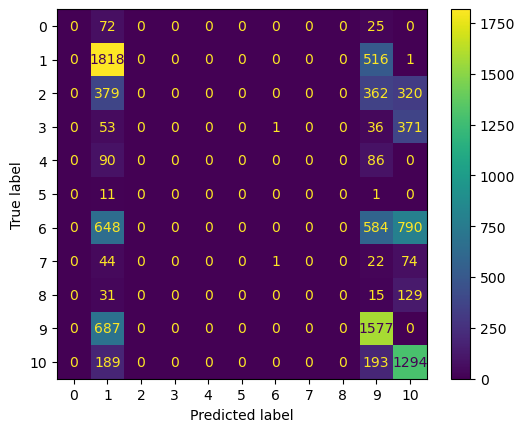

In [27]:
cm = confusion_matrix(y_train_lg, y_train_pred_lg)
ConfusionMatrixDisplay.from_estimator(log_model_tunned, X_train_lg, y_train_lg)

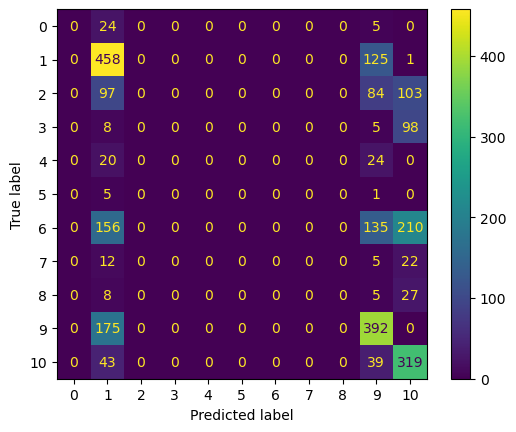

In [28]:
cm = confusion_matrix(y_test_lg, y_test_pred_lg)
ConfusionMatrixDisplay.from_estimator(log_model_tunned, X_test_lg, y_test_lg)


Logistic Regresion without PCA components

In [29]:
X_lg = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y_lg= codon_df_clean['Kingdom_labels']


X_train_lgw, X_test_lgw, y_train_lgw, y_test_lgw = train_test_split(X_lg, y_lg, test_size=0.2, random_state=34)

In [31]:
scaler_LG = StandardScaler()

scaler_LG.fit(X_train_lgw)

X_train_scaled_lg = scaler_LG.transform(X_train_lgw)
X_test_scaled_lg = scaler_GNB.transform(X_test_lgw)

In [32]:
log_model_no_pca = LogisticRegression(max_iter=1000, random_state=34)
log_model_no_pca.fit(X_train_scaled_lg, y_train_lgw)

LogisticRegression(max_iter=1000, random_state=34)

In [33]:
y_train_pred_lg_1 = log_model_no_pca.predict(X_train_scaled_lg)
y_test_pred_lg_1 = log_model_no_pca.predict(X_test_scaled_lg)

In [34]:
test_accuracy_1 = accuracy_score(y_test_lgw, y_test_pred_lg_1)
print(test_accuracy_1)

0.8787413660782809


In [35]:
report_test_no_pca = classification_report(y_test_lgw, y_test_pred_lg_1)
print(report_test_no_pca)

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        29
           1       0.93      0.94      0.94       584
           2       0.77      0.71      0.74       284
           3       0.83      0.84      0.83       111
           4       0.83      0.68      0.75        44
           5       0.00      0.00      0.00         6
           6       0.87      0.88      0.87       501
           7       0.70      0.49      0.58        39
           8       0.67      0.65      0.66        40
           9       0.90      0.93      0.91       567
          10       0.92      0.94      0.93       401

    accuracy                           0.88      2606
   macro avg       0.75      0.71      0.73      2606
weighted avg       0.87      0.88      0.88      2606



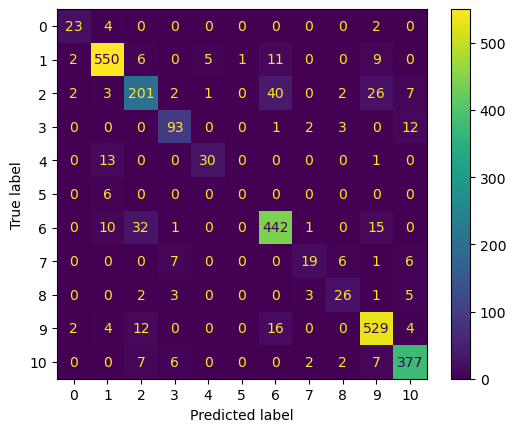

In [36]:
cm1 = confusion_matrix(y_test_lgw, y_test_pred_lg_1)
ConfusionMatrixDisplay.from_estimator(log_model_no_pca, X_test_scaled_lg, y_test_lgw)


## KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
X_2 = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y_2= codon_df_clean['Kingdom_labels']


X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_2, y_2, test_size=0.2, random_state=34)

In [39]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [3, 5, 7, 10],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

In [40]:
grid_search_knn = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=4, scoring='accuracy')
grid_search_knn.fit(X_train_knn, y_train_knn)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=4,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
                         'knn__n_neighbors': [3, 5, 7, 10],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [41]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [42]:
knn_model_tunned = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan')
knn_model_tunned.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [43]:
y_pred_test = knn_model_tunned.predict(X_test_knn)
y_pred_train = knn_model_tunned.predict(X_train_knn)

In [44]:
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.3933231005372218


In [45]:
report_train = classification_report(y_train_knn, y_pred_train)
print(report_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00      2335
           2       1.00      1.00      1.00      1061
           3       1.00      1.00      1.00       461
           4       1.00      1.00      1.00       176
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00      2022
           7       1.00      1.00      1.00       141
           8       1.00      1.00      1.00       175
           9       1.00      1.00      1.00      2264
          10       1.00      1.00      1.00      1676

    accuracy                           1.00     10420
   macro avg       1.00      1.00      1.00     10420
weighted avg       1.00      1.00      1.00     10420



In [46]:
report_test = classification_report(y_test_knn, y_pred_test)
print(report_test)

              precision    recall  f1-score   support

           0       0.10      0.07      0.08        29
           1       0.40      0.41      0.41       584
           2       0.20      0.15      0.17       284
           3       0.43      0.41      0.42       111
           4       0.31      0.36      0.34        44
           5       0.00      0.00      0.00         6
           6       0.39      0.37      0.38       501
           7       0.08      0.05      0.06        39
           8       0.30      0.33      0.31        40
           9       0.40      0.46      0.43       567
          10       0.53      0.55      0.54       401

    accuracy                           0.39      2606
   macro avg       0.28      0.29      0.28      2606
weighted avg       0.39      0.39      0.39      2606



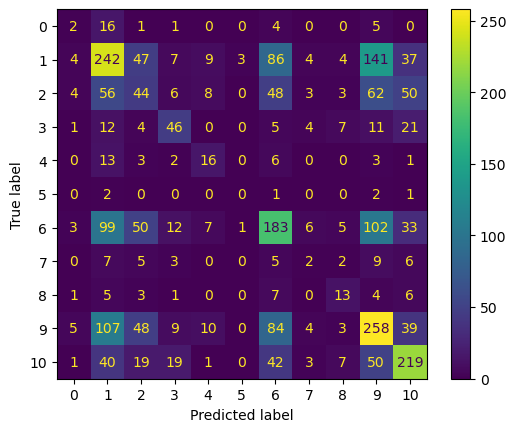

In [47]:
cm_test = confusion_matrix(y_test_knn, y_pred_test)
ConfusionMatrixDisplay.from_estimator(knn_model_tunned, X_test_knn, y_test_knn)


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
X_3 = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y_3= codon_df_clean['Kingdom_labels']


X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_3, y_3, test_size=0.2, random_state=34)

In [50]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier(random_state=34))
])

In [51]:
param_grid_rf = {
    'pca__n_components': [40, 45],
    'rf__n_estimators': [200, 300, 350],
    'rf__max_depth': [30, 35],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

In [52]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, n_jobs=4, scoring='accuracy')
grid_search_rf.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('rf',
                                        RandomForestClassifier(random_state=34))]),
             n_jobs=4,
             param_grid={'pca__n_components': [40, 45],
                         'rf__max_depth': [30, 35],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [200, 300, 350]},
             scoring='accuracy')

In [53]:
# 20 minutes 
print("Best parameters found: ", grid_search_rf.best_params_)

Best parameters found:  {'pca__n_components': 45, 'rf__max_depth': 35, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


In [55]:
rf_model_tunned = RandomForestClassifier(random_state=34, n_estimators=300, max_depth=35, min_samples_leaf=1, min_samples_split=2)
rf_model_tunned.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=35, n_estimators=300, random_state=34)

In [56]:
best_pipeline_rf = grid_search_rf.best_estimator_
y_pred_rf = best_pipeline_rf.predict(X_test_rf)

In [57]:
print("Classification Test Report:")
print(classification_report(y_test_rf, y_pred_rf))
print("Accuracy Score:", accuracy_score(y_test_rf, y_pred_rf))

Classification Test Report:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68        29
           1       0.90      0.97      0.93       584
           2       0.91      0.74      0.82       284
           3       0.92      0.88      0.90       111
           4       0.93      0.57      0.70        44
           5       0.00      0.00      0.00         6
           6       0.92      0.93      0.93       501
           7       0.90      0.49      0.63        39
           8       1.00      0.60      0.75        40
           9       0.89      0.98      0.93       567
          10       0.90      0.97      0.93       401

    accuracy                           0.91      2606
   macro avg       0.84      0.69      0.75      2606
weighted avg       0.91      0.91      0.90      2606

Accuracy Score: 0.9071373752877974


c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


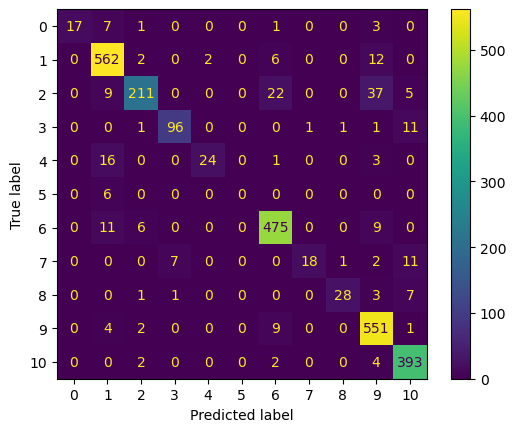

In [58]:
rf_test = confusion_matrix(y_test_rf, y_pred_rf)
ConfusionMatrixDisplay.from_estimator(rf_model_tunned, X_test_rf, y_test_rf)


In [59]:
from sklearn import tree
from sklearn.tree import plot_tree

In [60]:
best_rf = best_pipeline_rf.named_steps['rf']
n_components = best_pipeline_rf.named_steps['pca'].n_components_
feature_names = [f'PC{i+1}' for i in range(n_components)]
importances = best_rf.feature_importances_

In [61]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

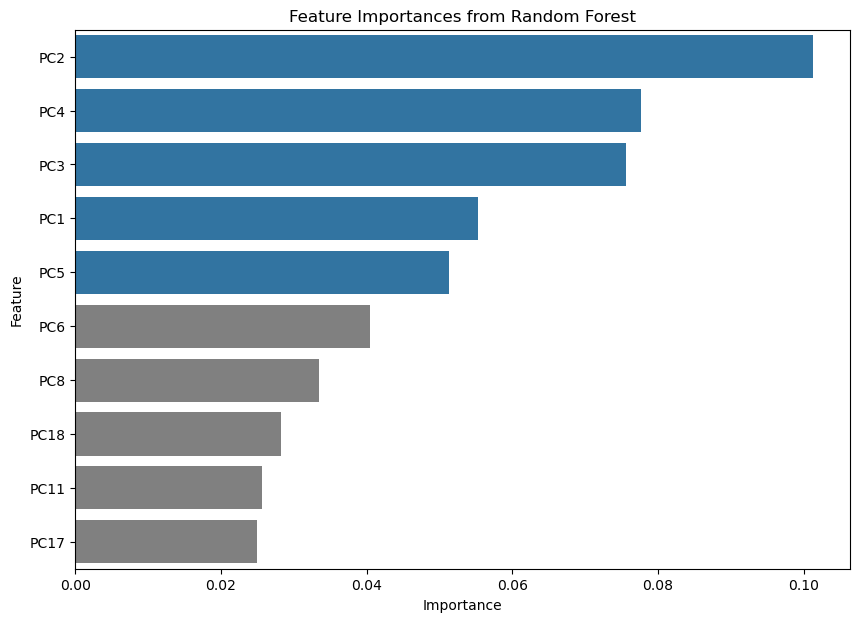

In [62]:
top_10_features = feature_importance_df.head(10)
palette = ['#1f77b4' if i < 5 else 'gray' for i in range(len(feature_importance_df))]
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=top_10_features, palette=palette)
plt.title('Feature Importances from Random Forest')
plt.show()

In [63]:
pca_rf = PCA(n_components=45)
pca_rf.fit(X_train_rf)
pca_rf.components_

array([[-6.94400941e-08,  1.00000000e+00, -1.16024892e-09, ...,
        -8.61372738e-11,  2.31057864e-12, -9.17171204e-10],
       [ 9.99126245e-01,  6.96422551e-08,  1.14220840e-02, ...,
         3.24459296e-04, -3.84871429e-05,  6.68781330e-03],
       [ 2.07424268e-02, -2.99510469e-09, -2.14078714e-01, ...,
        -5.91079330e-03, -3.26276224e-04,  3.26721126e-02],
       ...,
       [-0.00000000e+00, -3.10853567e-11, -7.35920655e-02, ...,
         3.92456865e-03, -2.21524608e-03,  7.99272235e-03],
       [ 0.00000000e+00, -1.26619671e-10,  3.83785463e-03, ...,
         6.31694429e-02,  1.98887480e-02, -1.32727611e-01],
       [ 0.00000000e+00, -3.94522704e-11,  4.55146499e-02, ...,
         3.06095391e-02,  6.21585835e-03,  2.85922260e-02]])

In [64]:
loadings = pca_rf.components_
loadings_df = pd.DataFrame(loadings, columns=X_train_rf.columns)

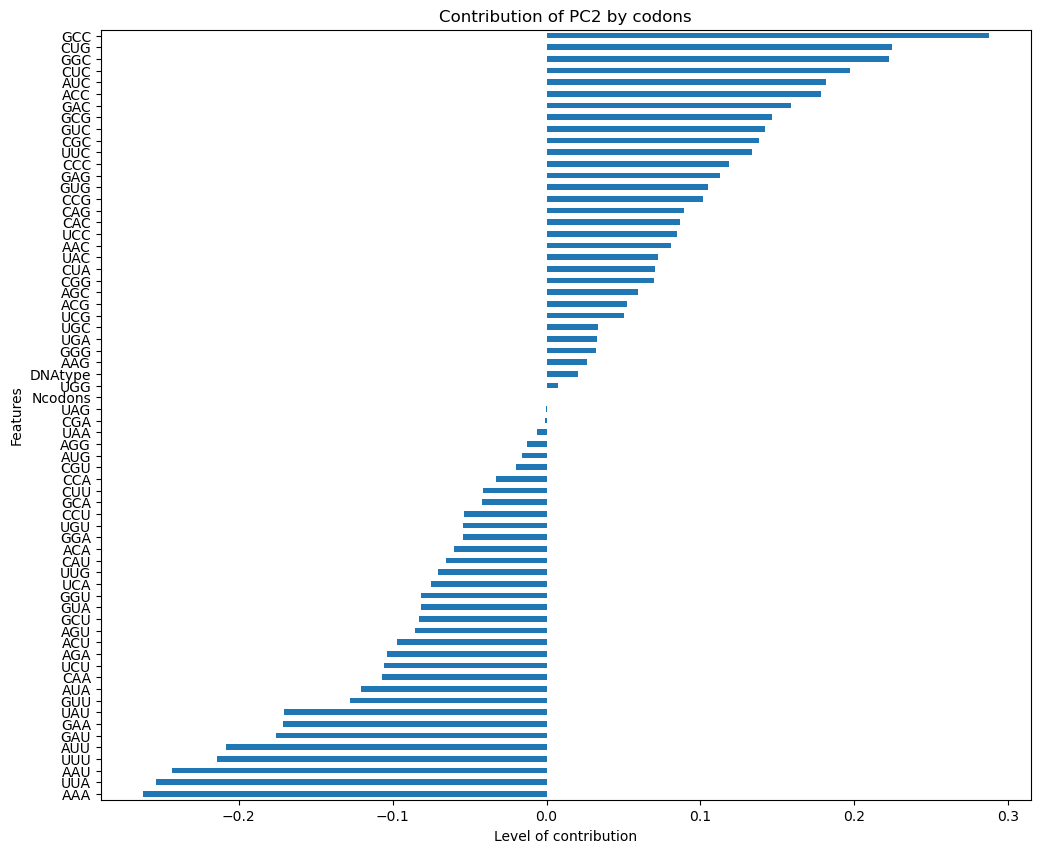

In [65]:
plt.figure(figsize=(12,10))
loadings_df.iloc[2, :].sort_values().plot(kind='barh')
plt.ylabel('Features')
plt.xlabel('Level of contribution')
plt.title('Contribution of PC2 by codons')
plt.show()

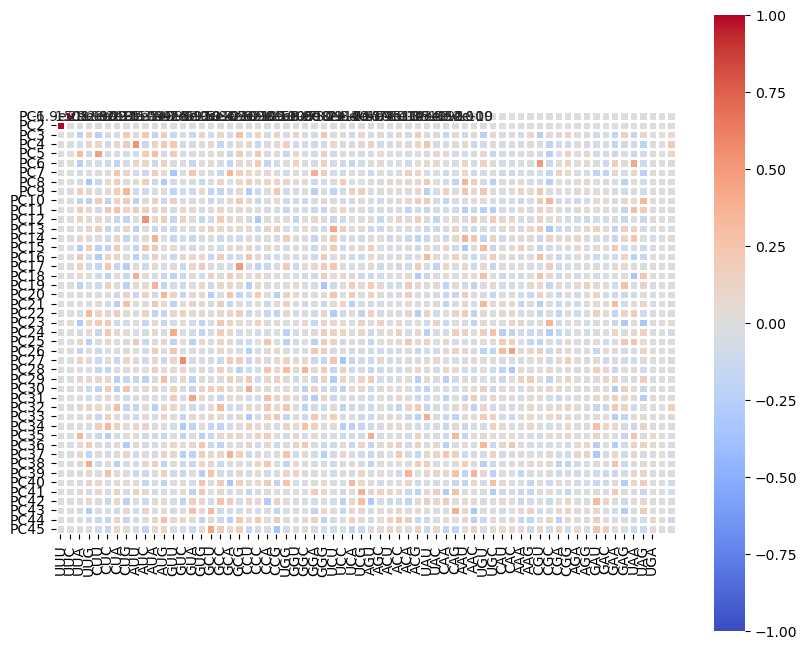

In [66]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(pca_rf.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PC"+str(x) for x in range(1,pca_rf.n_components_+1)],
                 xticklabels=list(X_train_rf.columns[2:]),
                 linewidths = 1,
                 annot = True,
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=90)
ax.set_aspect("equal")
plt.show()

In [67]:
single_tree = best_rf.estimators_[0]

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10), dpi=900)
plot_tree(single_tree, 
          feature_names=feature_names, 
          class_names=[str(i) for i in np.unique(y_train_rf)], 
          filled=True, 
          rounded=True,
          impurity=True,
          max_depth=2)
plt.show()

Desicion Tree without PCA

In [85]:
X_3_ = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y_3_= codon_df_clean['Kingdom_labels']


X_train_rf_1, X_test_rf_1, y_train_rf_1, y_test_rf_1 = train_test_split(X_3_, y_3_, test_size=0.2, random_state=34)

In [86]:
scaler_RDF = StandardScaler()

scaler_RDF.fit(X_train_rf_1)

X_train_scaled_rf = scaler_RDF.transform(X_train_rf_1)
X_test_scaled_rf = scaler_RDF.transform(X_test_rf_1)

In [87]:
rf_model = RandomForestClassifier(random_state=34, n_estimators=300, max_depth=35, min_samples_leaf=1, min_samples_split=2)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_depth=35, n_estimators=300, random_state=34)

In [89]:
y_pred_rf_1 = rf_model.predict(X_test_scaled_rf)

c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [90]:
accuracy_rf = accuracy_score(y_test_rf_1, y_pred_rf_1)
print(f'Accuracy: {accuracy_rf:.2f}')

Accuracy: 0.65


In [92]:
report_rf = classification_report(y_test_rf_1, y_pred_rf_1)
print(report_rf)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.68      0.92      0.78       584
           2       0.46      0.62      0.52       284
           3       1.00      0.02      0.04       111
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00         6
           6       0.56      0.68      0.61       501
           7       0.00      0.00      0.00        39
           8       0.44      0.38      0.41        40
           9       0.92      0.46      0.61       567
          10       0.70      0.89      0.79       401

    accuracy                           0.65      2606
   macro avg       0.43      0.36      0.34      2606
weighted avg       0.67      0.65      0.61      2606



c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Inspect feature importance, which tells which features were most influential in making predictions.

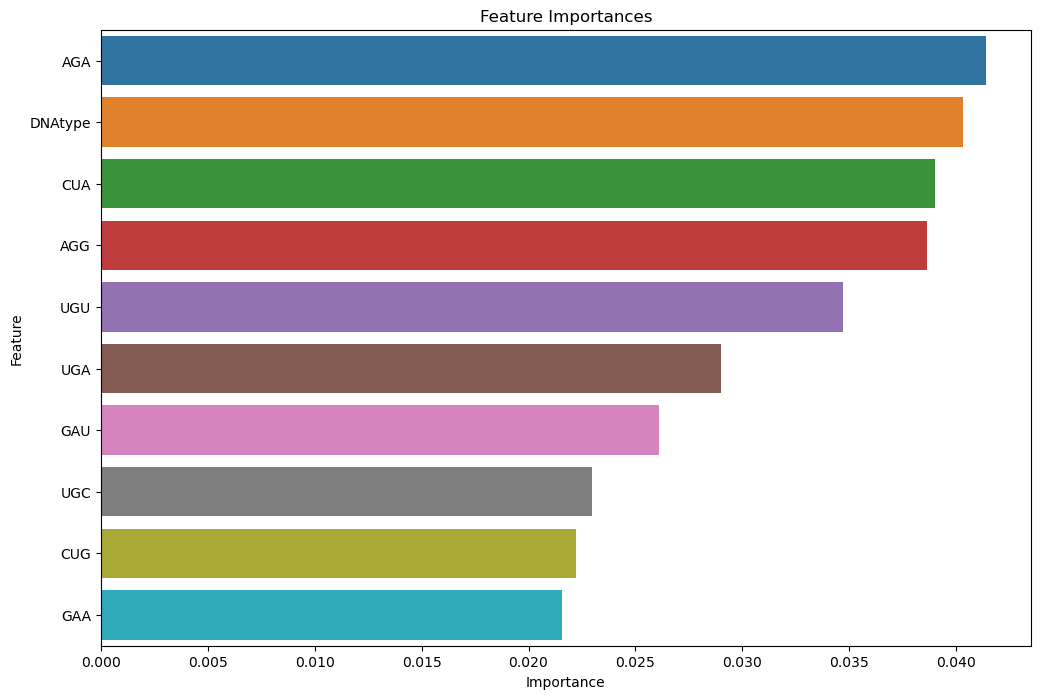

In [94]:
feature_importances = rf_model.feature_importances_
feature_names = X_3_.columns

# Creating a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.show()

## Clustering

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [70]:
codon_df_scaled = codon_df_clean.drop(columns=['Kingdom', 'SpeciesID', 'Ncodons', 'SpeciesName','DNAtype', 'Kingdom_labels' ])
codon_df_scaled

,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,AUC,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0.01654,0.01203,0.00050,0.00351,0.01203,0.03208,0.00100,0.04010,0.00551,0.02005,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,0.02714,0.01357,0.00068,0.00678,0.00407,0.02849,0.00204,0.04410,0.01153,0.02510,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,0.01974,0.02180,0.01357,0.01543,0.00782,0.01111,0.01028,0.01193,0.02283,0.01604,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,0.01775,0.02245,0.01619,0.00992,0.01567,0.01358,0.00940,0.01723,0.02402,0.02245,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,0.02816,0.01371,0.00767,0.03679,0.01380,0.00548,0.00473,0.02076,0.02716,0.00867,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13023,0.02552,0.03555,0.00547,0.01367,0.01276,0.02097,0.00820,0.03555,0.01459,0.03920,...,0.00820,0.01367,0.01094,0.01367,0.02279,0.02005,0.04102,0.00091,0.00091,0.00638
13024,0.01258,0.03193,0.01984,0.00629,0.01451,0.05322,0.07644,0.01258,0.03096,0.06386,...,0.00145,0.00000,0.00048,0.00194,0.01306,0.01838,0.00677,0.00242,0.00097,0.01887
13025,0.01423,0.03321,0.01661,0.00356,0.01127,0.05042,0.09609,0.01068,0.02728,0.06643,...,0.00000,0.00000,0.00000,0.00178,0.01661,0.02788,0.00297,0.00356,0.00119,0.02017
13026,0.01757,0.02028,0.00767,0.01293,0.01319,0.01959,0.00715,0.03964,0.01600,0.02082,...,0.01142,0.01217,0.01196,0.02178,0.02510,0.02896,0.03959,0.00099,0.00079,0.00156


I know that our target is divide by 10 classes. So as a test lets explore if using k as 10 will shown 10 clusters 

In [71]:
kmeans1 = KMeans(n_clusters= 10)
kmeans1_labels = kmeans1.fit_predict(codon_df_scaled)

agg1 = AgglomerativeClustering(n_clusters = 10 , linkage='ward')
agg1_labels = agg1.fit_predict(codon_df_scaled)

gmm1 = GaussianMixture(n_components = 10)
gmm1_labels = gmm1.fit_predict(codon_df_scaled)

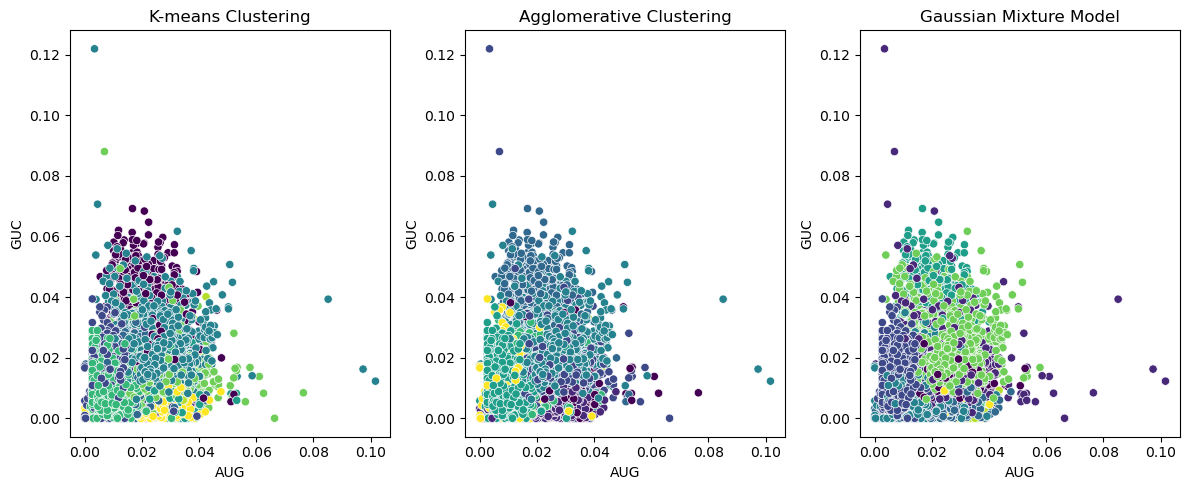

In [72]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='AUG', y='GUC', hue=kmeans1_labels, palette='viridis', data=codon_df_scaled, legend=False)
plt.title('K-means Clustering')


plt.subplot(1, 3, 2)
sns.scatterplot(x='AUG', y='GUC', hue=agg1_labels, palette='viridis', data=codon_df_scaled, legend=False)
plt.title('Agglomerative Clustering')


plt.subplot(1, 3, 3)
sns.scatterplot(x='AUG', y='GUC', hue=gmm1_labels, palette='viridis', data=codon_df_scaled, legend=False)
plt.title('Gaussian Mixture Model')

plt.tight_layout()
plt.show()

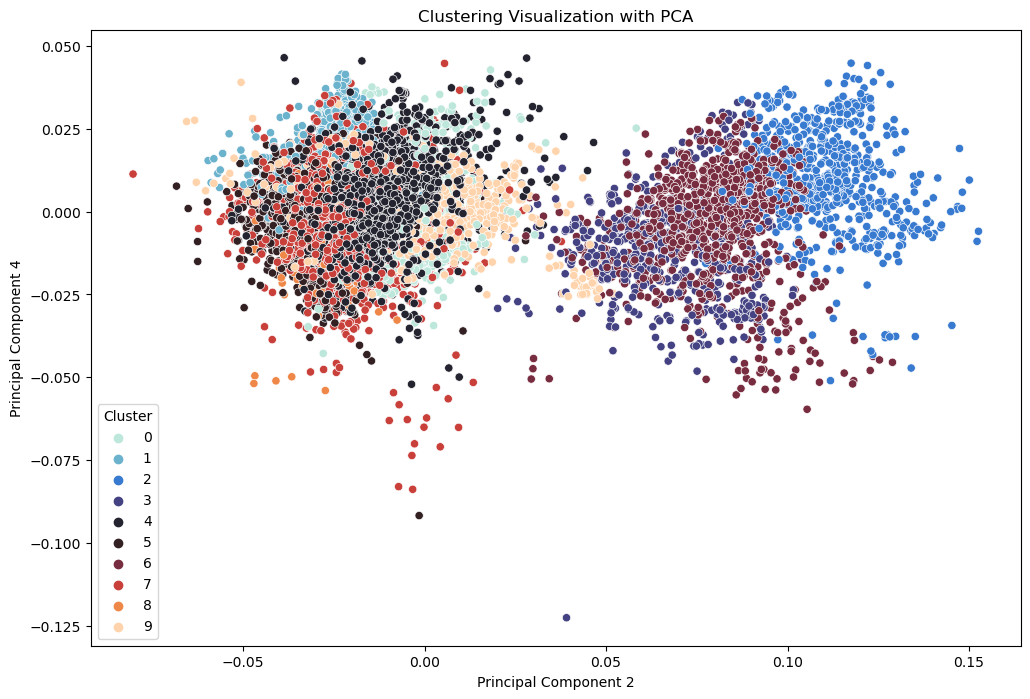

In [73]:
pca_clustering = PCA(n_components=10)
principal_components = pca_clustering.fit_transform(codon_df_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=principal_components[:, 1], y=principal_components[:, 5], hue=kmeans1_labels, palette='icefire', legend='full')
plt.title('Clustering Visualization with PCA')

plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')
plt.legend(title='Cluster', loc='best')

plt.show()

c:\Users\pier3\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


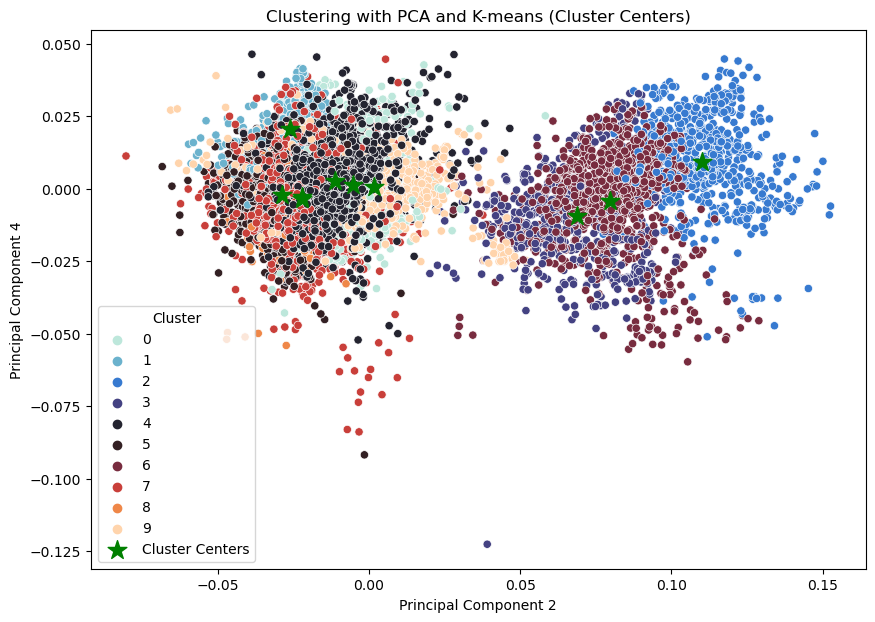

In [74]:
cluster_centers_pca = pca_clustering.transform(kmeans1.cluster_centers_)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=principal_components[:, 1], y=principal_components[:, 5], hue=kmeans1_labels, palette='icefire', legend='full')
plt.scatter(cluster_centers_pca[:, 1], cluster_centers_pca[:, 5], marker='*', color='green', s=200, label='Cluster Centers')
plt.title('Clustering with PCA and K-means (Cluster Centers)')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 4')
plt.legend(title='Cluster', loc='best')
plt.show()

In [75]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [76]:
silhouette_avg_kmeans = silhouette_score(codon_df_scaled, kmeans1_labels)
print(f"Silhouette Score for K-means clustering: {silhouette_avg_kmeans}")

silhouette_avg_agg = silhouette_score(codon_df_scaled, agg1_labels)
print(f"Silhouette Score for Agglomerative clustering: {silhouette_avg_agg}")

silhouette_avg_gmm = silhouette_score(codon_df_scaled, gmm1_labels)
print(f"Silhouette Score for Gaussian Mixture clustering: {silhouette_avg_gmm}")


Silhouette Score for K-means clustering: 0.1525911324775197
Silhouette Score for Agglomerative clustering: 0.1304323386668715
Silhouette Score for Gaussian Mixture clustering: 0.10233700532085034


The differences in silhouette scores between these methods are relatively small, indicating that all three algorithms perform similarly on your dataset in terms of clustering quality based on silhouette analysis.

In [77]:
from sklearn.metrics import rand_score

In [78]:
print(f'This is the rand score for kmeans and agg {rand_score(kmeans1_labels, agg1_labels)}')
print(f'This is the rand score for kmeans and gmm {rand_score(kmeans1_labels, gmm1_labels)}')

This is the rand score for kmeans and agg 0.9030749367940628
This is the rand score for kmeans and gmm 0.8575095490401156


The Rand score of approximately 0.87 and 0.85 indicates a high level of agreement or similarity between the clusterings produced by K-means and Agglomerative Clustering and K-means and Gaussian Mixture Model. This suggests that the two clustering algorithms data points to clusters in a very similar manner.

Using k=10 didnt shown 10 clusters therefore lets find the best k for this dataset

In [79]:
silScoreKmeans = []
silScoresGauss =[]
silScoresAgglom =[]

ks = np.arange(2,11)

for k in ks:

    print(f'currently working on kmeans with k={k}')
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(codon_df_scaled)
    kmeans_score = silhouette_score(codon_df_scaled, kmeans.labels_)
    silScoreKmeans.append(kmeans_score)

    print(f'currently working on gmm with k={k}')
    gmm = GaussianMixture(n_components=k)
    gmm.fit(codon_df_scaled)
    gmm_score = silhouette_score(codon_df_scaled, gmm.predict(codon_df_scaled))
    silScoresGauss.append(gmm_score)

    #fit hierarchichal (agglomerative)
    print(f'currently working on agg with k={k}')
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    agg.fit(codon_df_scaled)
    agg_score = silhouette_score(codon_df_scaled, agg.labels_)
    silScoresAgglom.append(agg_score)

currently working on kmeans with k=2
currently working on gmm with k=2
currently working on agg with k=2
currently working on kmeans with k=3
currently working on gmm with k=3
currently working on agg with k=3
currently working on kmeans with k=4
currently working on gmm with k=4
currently working on agg with k=4
currently working on kmeans with k=5
currently working on gmm with k=5
currently working on agg with k=5
currently working on kmeans with k=6
currently working on gmm with k=6
currently working on agg with k=6
currently working on kmeans with k=7
currently working on gmm with k=7
currently working on agg with k=7
currently working on kmeans with k=8
currently working on gmm with k=8
currently working on agg with k=8
currently working on kmeans with k=9
currently working on gmm with k=9
currently working on agg with k=9
currently working on kmeans with k=10
currently working on gmm with k=10
currently working on agg with k=10


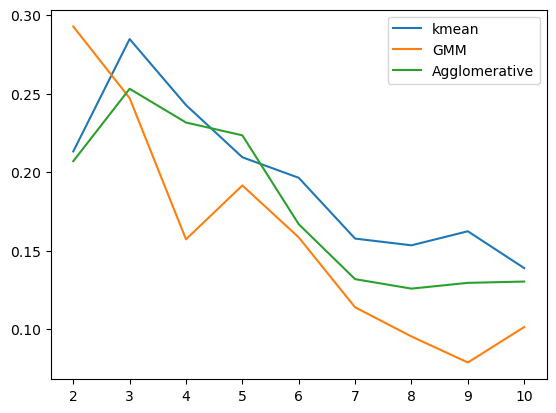

In [80]:
plt.figure()
plt.plot(ks, silScoreKmeans, label='kmean')
plt.plot(ks, silScoresGauss, label='GMM')
plt.plot(ks, silScoresAgglom, label='Agglomerative')
plt.legend()
plt.show()

In [81]:
kmeans2 = KMeans(n_clusters=3)
kmeans2_labels = kmeans2.fit_predict(codon_df_scaled)

agg2 = AgglomerativeClustering(n_clusters = 3, linkage='ward')
agg2_labels = agg2.fit_predict(codon_df_scaled)

gmm2 = GaussianMixture(n_components = 3)
gmm2_labels = gmm2.fit_predict(codon_df_scaled)

In [83]:
silhouette_avg_kmeans2 = silhouette_score(codon_df_scaled, kmeans2_labels)
print(f"Silhouette Score for K-means clustering: {silhouette_avg_kmeans2}")

silhouette_avg_agg2 = silhouette_score(codon_df_scaled, agg2_labels)
print(f"Silhouette Score for Agglomerative clustering: {silhouette_avg_agg2}")

silhouette_avg_gmm2 = silhouette_score(codon_df_scaled, gmm2_labels)
print(f"Silhouette Score for Gaussian clustering: {silhouette_avg_gmm2}")

Silhouette Score for K-means clustering: 0.284644610089352
Silhouette Score for Agglomerative clustering: 0.2530188313144958
Silhouette Score for Gaussian clustering: 0.24740986318891026


In [84]:
print(f'This is the rand score with k= 3 for kmeans and agg: {rand_score(kmeans2_labels, agg2_labels)}')
print(f'This is the rand score with k= 3 for kmeans and gaussina: {rand_score(kmeans2_labels, gmm2_labels)}')

This is the rand score with k= 3 for kmeans and agg: 0.7183518331711006
This is the rand score with k= 3 for kmeans and gaussina: 0.813981250550722


The Rand index score of 0.7151 for K-means and Agglomerative Clustering (agg) with k=3 indicates a high level of agreement between the clusterings